## Project: Search and Sample Return

**Introduction**

The search and sample return project was designed (by the [Udacity](https://www.udacity.com/course/robotics-software-engineer--nd209) team) to give participants experince in the three essential elements of robotics:
* Perception
* Decision Making
* Action

The project was modelled on the [NASA sample return challenge](https://www.nasa.gov/directorates/spacetech/centennial_challenges/sample_return_robot/about.html), which has the overall goal of <i>programming a rover to autonomously map an environment while searching for rock samples of interest</i>.

<p>The project utilized the Unity game engine to simulate an environment of a Rover on Mars, surrounded by rock-walls (unnavagable terrain) and rock-samples as shown in the image below:</p>

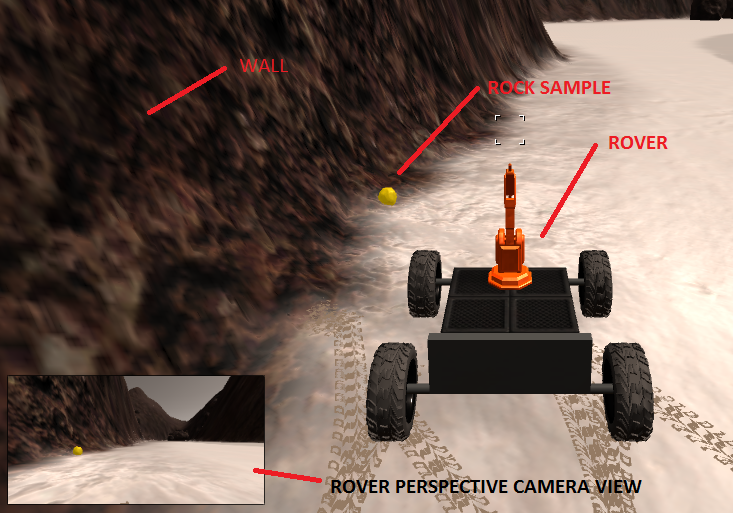

<p>Under the conditions perscribed by the environment, the task was to take images from the rover's perspective camera, perform transforms on the images to map them to a top-down view of the environment, and then apply various computer-vision techniques in order to classify different parts of the environemnt. With the environment classified, the task was to create a decision tree for the Rover to be able to navigate and map the environment in a logical way, identifying traversible area, obstacles, and rock samples along the way.</p>


**Training / Calibration**  

<p>To train and calibrate the Rover's perception algorithms, a Jupyter notebook environment was used, which can be found [here](code/Rover_Project_Test_Notebook.ipynb). The process_image() function was formed such that it could output a video that successfully maps the environment by using test images gathered in the training simulator. In order to succesfully reproduce these test images (and to run autonomously), one must be sure to use the proper simulator parameters listed here: </p>

* Resoultion: 1024 x 768
* Graphics Quality: "Good"
* Windowed mode enabled: True

<p>To see a sample video that is produced with the `process_image()` function, see [here](Writeup Images/Mapping.mp4) </p>

**Autonomous Navigation / Mapping**

<p> In order to complete the Autonomous Navigation/Mapping Step, various python files were edited which can be found in the `code` directory of this repository; these files are as stated:</p>
* `perception.py` - for percieving the environment
* `decision.py` - for making decisions on how to drive the Rover based on the environment
* `drive_rover.py` - for keeping a handle on the Rover's state, and communicating with the simulator
* `supporting_functions.py` - for creating simulator input data, and parsing output data.

<p> These files were edited such to make the rover autonomously map the environment: making the rover steer, brake, and accelerate when necessary based on its percieved environment.


**Perception Of Navigable Terrain, Obstacles, and Rocks**

The rover's onboard camera recieves an image (as shown below) at a certain framerate (images/second). This image displays the environment directly infront of the rover:

<img src="Writeup%20Images/Rover%20Percieved%20Environment.png" width="80%">

In order to make use of this image, it needs to be classified into different elements based on noticeable patterns. Utilizing OpenCV, the image can be converted into black and white:

<img src="Writeup%20Images/Rover%20Percieved%20Environment%20BW.png" width="80%">

It is relatively easy to detect which pixels are navagatable based on how bright the pixels are in the above image. Using a simple threshold in the function `bw_thresh()`, the navigatable pixels can be returned and shown as follows (and once the navigable pixels are found, the obstacles are just the inverse!):

<img src="Writeup%20Images/Rover%20Percieved%20Environment%20Thresholded.png" width="80%">

To find the rocks (the yellow samples of interest - see function `rock_thresh()`), it is almost the same. First, the original percieved image is converted to a [HSV colour space](https://en.wikipedia.org/wiki/HSL_and_HSV):

<img src="Writeup%20Images/Rover%20Percieved%20Environment%20HSV.png" width="80%">

and then the rocks are thresholded based on their second colour channel (saturation):

<img src="Writeup%20Images/Rover%20Percieved%20Environment%20Rocks.png" width="80%">

For each of these images, the sky was also cut out of the top with `cut_top_of_colored_image()`, noting that it was usually contained in the first 60 pixel rows or so.

**Tranformation of Percieved Data Into World Coordinates**

In order to be of great use, the percieved data gathered above must be transferable into more friendly coordinate system. The rover simulator provides a 'Grid Mode' which allows for a 1x1 meter grid to be overlayed across the entire map of the environment as shown:

<img src="Writeup%20Images/Grid.png" width="80%">

From this grid, an image is taken and the four corners are read to be as follows:

* Bottom Left: [6.7,145.5] 
* Bottom Right: [306.1, 142.7]
* Top Right: [ 197.7, 96.8]
* Top Left: [118.2, 96.7]

These datapoints, taken together can be termed the `source` points. A top-down image of this same data is desired such that a map of the environment can be made. A choice of `destination` points can be chosen such that a mapping matrix, `M`, can convert the `source` data-space into the `destination` data-space. In the function `perspect_tranform` the destination points are chosen such that the rovers perceieved data-space is mapped to the bottom-middle of the top-down data-space as shown:

<img src="Writeup%20Images/Top-down.png" width="80%">


When `perspect_transform` is used on the tresholded data gathered above, a top-down view as shown below is obtained, as would be expected:

<img src="Writeup%20Images/Top%20Down%20Threshed.png" width="80%">

This data can then be translated and rotated into a coordinate system such that the rover is a the center (0,0), with the x-axis in the direction that the camera is facing. This is computed utilizing the `rover_coords()` function and the plotted output is as follows:

<img src="Writeup%20Images/Rover_centric.png" width="80%">

From this data, the polar coordinates can be found using `to_polar_coords()` to be later used in future decision making processes. 

Finally, the rover centric coordinates can be again translated, rotated, and scaled to be transformed into world coordinates based on telemetry data from the rover. These world coordinates can be later used to compose a map of the environment. The world coordinates are calculated with the `pix_to_world()` functions


**Processing The Images and Mapping the Terrain**

In `process_image()`, the above steps are performed in succcession of one another in order to return the world coordinates of rocks, the navigable terrain, and obstacles. `get_navigible_terrain_world_coordinates()`, `get_rock_world_coordinates()`, and `get_obstacle_world_coordinates()`, all take in rover-perspective images, apply the associated thresholds required, filter the data, and return the world coordinates of the respective data. These functions filter their data by filtering out datapoints that are too far away to be considered as valid (8m), and too far outside of a certain angle range (this is due to the 2D perspective transform not being as valid outside of a certain range).

Once `process_image()` has the necessary world coordinates, it adds them to their respective channel of an array the size of the master map that is intitially zeroed. For each step of `process_image()`, the channel with highest value 'wins' and therefore on the master map it is considered to be of this type. For example, if we have percieved element (10,10) to be navigable 20 times and an obstacle 21 times, we would consider the associated coordinate on the world map to be an obstacle. At each step of `process_image()` the final world map is updated to be displayed.


**Autonomous Decision Making Based on Percieved Data**

In order to navigate autonomously, the rover must make decisions based on percieved data. In this case, the decisions the rover makes based on this data is structured in the form of a [decision tree](https://en.wikipedia.org/wiki/Decision_tree). The decision tree code, which can be found in `decision.py` is structured such that the rover is meant to find a wall on the boundary of the map, and follow that wall around the map while mapping obstacles, navigable terrain, and rocks along the way. 

First the rover starts in "Find wall" mode; it will accelerate (to it's max velocity) forwards in the path of maximum navigable area (based on a mean of the polar angles). Once the Rover finds the wall, it will attempt to follow it; if the rover loses sight of the wall (based on a certain threshold of pixels on the rovers left - computed with `wall_on_left_set()` in `perception.py`), it will agressively steer left. If the rover has lost sight of the wall for too long, it will stop and turn left until it finds the wall ("Lost Wall" mode). At any point, if the rover's path is interupted for too long (based on output from `clear_path()` in `decision.py`), the rover will enter "Disrupted Path" mode. If on the other hand, the rover is not moving for a long time (based on telemetry position), but thinks it has a clear path: it will enter into "Stuck" mode.

When the rover is in "Disrupted Path" mode, it will stop and turn right until it finds a clear path.

When the rover is in "Stuck" mode, it will stop and turn right a full 90 degrees. 

Note that the funtionality for losing a wall and having a distrupted path is time based. This was to ensure that the rover did not continously think that it lost the wall or had a disrupted path after going below a threshold for only a short amount of time due to random noise. It was a simple measure to put in place in order to 'smooth' out/slow down the control system. 

In the case that the rover detects a rock, it goes into "ROCK" mode for a certain amount of time. In this time it steers and accelerates towards the rock that it has detected. If it does not pick up the rock in this time, it goes into  "Stuck" mode and proceeds as usual. 


**Mapping Results**

The rover regularly maps the desired environment with over 85% fidelity and over 90% mapped, while locating and picking up the majority of rocks. 

**Future Improvements**





### Autonomous Navigation and Mapping

#### 1. Fill in the `perception_step()` (at the bottom of the `perception.py` script) and `decision_step()` (in `decision.py`) functions in the autonomous mapping scripts and an explanation is provided in the writeup of how and why these functions were modified as they were.


#### 2. Launching in autonomous mode your rover can navigate and map autonomously.  Explain your results and how you might improve them in your writeup.  

**Note: running the simulator with different choices of resolution and graphics quality may produce different results, particularly on different machines!  Make a note of your simulator settings (resolution and graphics quality set on launch) and frames per second (FPS output to terminal by `drive_rover.py`) in your writeup when you submit the project so your reviewer can reproduce your results.**

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  



![alt text][image3]